In [149]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from unidecode import unidecode
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


In [150]:
# Fonction pour charger un fichier CSV
def load_csv(filename):
    return pd.read_csv(filename)

# Fonction pour charger un fichier JSON
def load_json(filename):
    with open(filename, 'r') as file:
        data = json.load(file)
    return pd.json_normalize(data)

# Fonction pour charger les données selon le type de fichier
def load_data(filename):
    if filename.endswith('.json'):
        return load_json(filename)
    elif filename.endswith('.csv'):
        return load_csv(filename)
    else:
        print("Unsupported file format")
        raise ValueError("Unsupported file format")


In [151]:
# Chargement des différents datasets
payments_data = load_data("./archive/olist_order_payments_dataset.csv")
reviews_data = load_data("./archive/olist_order_reviews_dataset.csv")
customers_data = load_data("./archive/olist_customers_dataset.csv")
geolocation_data = load_data("./archive/olist_geolocation_dataset.csv")
order_items_data = load_data("./archive/olist_order_items_dataset.csv")
products_data = load_data("./archive/olist_products_dataset.csv")
orders_data = load_data("./archive/olist_orders_dataset.csv")
sellers_data = load_data("./archive/olist_sellers_dataset.csv")
product_category_translation = load_data("./archive/product_category_name_translation.csv")


In [152]:
# Convertir les dates en type datetime
reviews_data['review_creation_date'] = pd.to_datetime(reviews_data['review_creation_date'], errors='coerce')
reviews_data['review_answer_timestamp'] = pd.to_datetime(reviews_data['review_answer_timestamp'], errors='coerce')

# Calculer le temps de réponse en jours
reviews_data['response_time'] = (reviews_data['review_answer_timestamp'] - reviews_data['review_creation_date']).dt.days

# Convertir la colonne 'payment_value' en numérique
payments_data['payment_value'] = pd.to_numeric(payments_data['payment_value'], errors='coerce')


In [153]:
# Fusionner tous les datasets pertinents pour créer un DataFrame complet
orders_merged = pd.merge(order_items_data, orders_data, on='order_id', how='left')
orders_customers_merged = pd.merge(orders_merged, customers_data, on='customer_id', how='left')
orders_products_merged = pd.merge(orders_customers_merged, products_data, on='product_id', how='left')
full_data = pd.merge(orders_products_merged, payments_data, on='order_id', how='left')
full_data = pd.merge(full_data, product_category_translation, on='product_category_name', how='left')


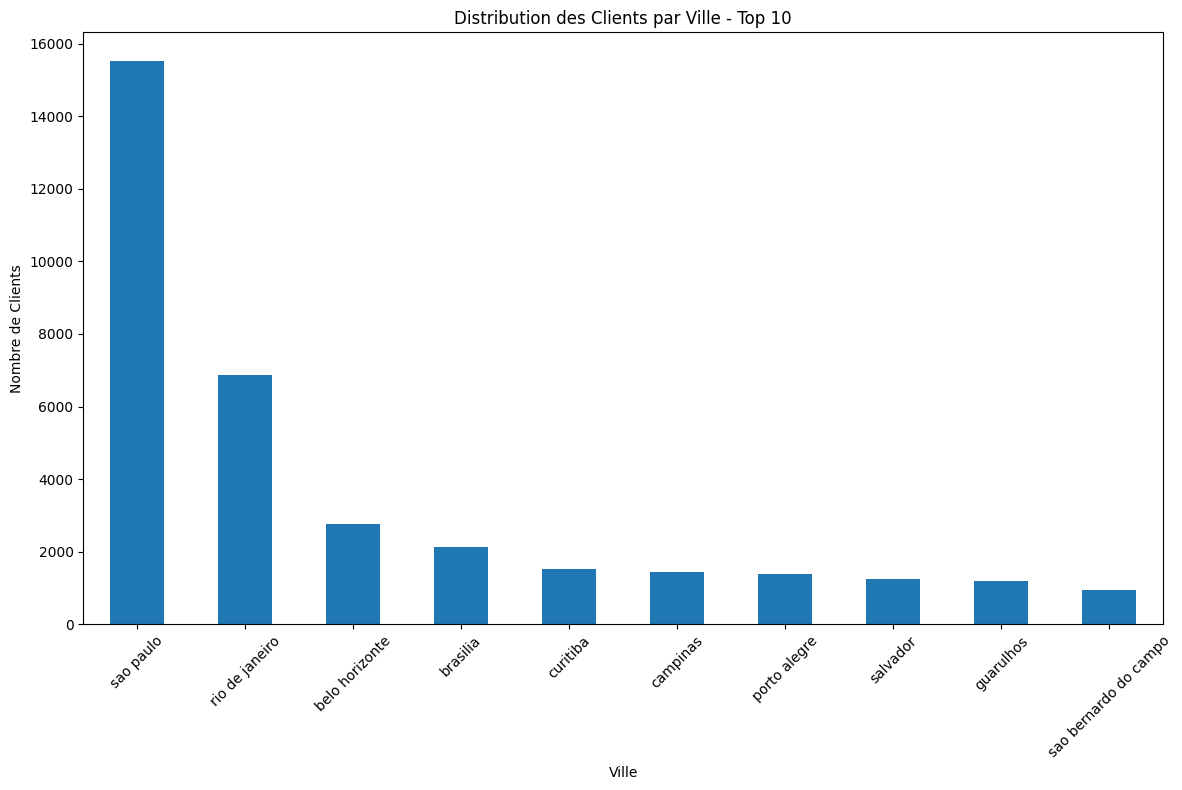

In [154]:
# Étudier la distribution des clients par ville pour identifier les marchés les plus importants.
customer_distribution = customers_data['customer_city'].value_counts()
top_cities = customer_distribution.head(10)

plt.figure(figsize=(12, 8))
top_cities.plot(kind='bar')
plt.title('Distribution des Clients par Ville - Top 10')
plt.xlabel('Ville')
plt.ylabel('Nombre de Clients')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [155]:
# Sélectionner les colonnes nécessaires pour l'analyse finale
selected_columns = full_data[['product_category_name_english', 'customer_city', 'payment_value', 'order_id', 'product_id', 'customer_id']]
selected_columns


,product_category_name_english,customer_city,payment_value,order_id,product_id,customer_id
0,cool_stuff,campos dos goytacazes,72.19,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,3ce436f183e68e07877b285a838db11a
1,pet_shop,santa fe do sul,259.83,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,f6dd3ec061db4e3987629fe6b26e5cce
2,furniture_decor,para de minas,216.87,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,6489ae5e4333f3693df5ad4372dab6d3
3,perfumery,atibaia,25.78,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,d4eb9395c8c0431ee92fce09860c5a06
4,garden_tools,varzea paulista,218.04,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,58dbd0b2d70206bf40e62cd34e84d795
...,...,...,...,...,...,...
117599,housewares,sao luis,343.40,fffc94f6ce00a00581880bf54a75a037,4aa6014eceb682077f9dc4bffebc05b0,b51593916b4b8e0d6f66f2ae24f2673d
117600,computers_accessories,curitiba,386.53,fffcd46ef2263f404302a634eb57f7eb,32e07fd915822b0765e448c4dd74c828,84c5d4fbaf120aae381fad077416eaa0
117601,sports_leisure,sao paulo,116.85,fffce4705a9662cd70adb13d4a31832d,72a30483855e2eafc67aee5dc2560482,29309aa813182aaddc9b259e31b870e6
117602,computers_accessories,vinhedo,64.71,fffe18544ffabc95dfada21779c9644f,9c422a519119dcad7575db5af1ba540e,b5e6afd5a41800fdf401e0272ca74655


In [156]:
# Étudier le type de produit le plus vendu dans chaque ville
product_sales_by_city = full_data.groupby(['customer_city', 'product_category_name_english']).size().reset_index(name='count')

city_sales = product_sales_by_city.groupby('customer_city')['count'].sum()
cities_to_consider = city_sales[city_sales > 10].index

filtered_product_sales_by_city = product_sales_by_city[product_sales_by_city['customer_city'].isin(cities_to_consider)]
most_sold_product_by_city = filtered_product_sales_by_city.loc[filtered_product_sales_by_city.groupby('customer_city')['count'].idxmax()]

sorted_most_sold_product_by_city = most_sold_product_by_city.sort_values(by='count', ascending=False)
unique_cities = filtered_product_sales_by_city['customer_city'].unique()


In [157]:
# Étudier le revenu total de chaque ville
total_revenue_by_city_reset = selected_columns.groupby('customer_city')['payment_value'].sum().reset_index()
total_revenue_by_city_reset.rename(columns={'payment_value': 'total_revenue'}, inplace=True)
total_revenue_by_city_reset = total_revenue_by_city_reset.sort_values(by='total_revenue', ascending=False)
total_revenue_by_city = total_revenue_by_city_reset.reset_index(drop=True)
print(total_revenue_by_city.head(30))


            customer_city  total_revenue
0               sao paulo     2839903.47
1          rio de janeiro     1566591.49
2          belo horizonte      501261.50
3                brasilia      430499.43
4                curitiba      329321.54
5            porto alegre      315729.22
6                salvador      289139.66
7                campinas      267039.20
8                 goiania      212702.97
9               guarulhos      205350.25
10                niteroi      175199.18
11              fortaleza      150971.54
12                 santos      150659.30
13  sao bernardo do campo      150027.88
14                 recife      129954.76
15          florianopolis      124513.36
16                jundiai      122555.04
17            santo andre      122298.38
18                 osasco      119307.03
19                  belem      112982.73
20    sao jose dos campos      110244.50
21               sorocaba      103544.08
22         ribeirao preto       93547.75
23              

In [158]:
# Charger les datasets pour la population des villes à partir d'un CSV externe
data_dictionary = pd.read_csv('./archive/BRAZIL_CITIES.csv', delimiter=';', quotechar='"', on_bad_lines='skip')

# Fonction pour normaliser les noms de villes
def normalize_city(city):
    return unidecode(city.lower())

data_dictionary['city_normalized'] = data_dictionary['CITY'].apply(normalize_city)
geolocation_data['city_normalized'] = geolocation_data['geolocation_city'].apply(normalize_city)

merged_data = pd.merge(data_dictionary, geolocation_data, on='city_normalized', how='inner')

cleaned_data = merged_data[['CITY', 'IBGE_RES_POP']]
cleaned_data = cleaned_data.drop_duplicates(subset=['CITY'], keep='first')
print(cleaned_data)


                        CITY  IBGE_RES_POP
0            Abadia De Goiás        6876.0
8        Abadia Dos Dourados        6704.0
34                 Abadiânia       15757.0
58                    Abaeté       22690.0
184               Abaetetuba      141100.0
...                      ...           ...
1069758          Xique-Xique       45536.0
1069825               Zabelê        2075.0
1069828             Zacarias        2335.0
1069842              Zé Doca       50173.0
1069888               Zortéa        2991.0

[5199 rows x 2 columns]


In [159]:
# Fusionner les tables cleaned_data et total_revenue_by_city
total_revenue_by_city['customer_city'] = total_revenue_by_city['customer_city'].apply(normalize_city)
cleaned_data['CITY'] = cleaned_data['CITY'].apply(normalize_city)
analysis_data = pd.merge(total_revenue_by_city, cleaned_data, left_on='customer_city', right_on='CITY', how='left')
client_counts = customers_data['customer_city'].value_counts().reset_index()
client_counts.columns = ['customer_city', 'num_clients']
client_counts['customer_city'] = client_counts['customer_city'].apply(normalize_city)
analysis_data = pd.merge(analysis_data, client_counts, on='customer_city', how='left')

print(analysis_data.head(10))


    customer_city  total_revenue            CITY  IBGE_RES_POP  num_clients
0       sao paulo     2839903.47       sao paulo    11253503.0        15540
1  rio de janeiro     1566591.49  rio de janeiro     6320446.0         6882
2  belo horizonte      501261.50  belo horizonte     2375151.0         2773
3        brasilia      430499.43        brasilia     2570160.0         2131
4        curitiba      329321.54        curitiba     1751907.0         1521
5    porto alegre      315729.22    porto alegre     1409351.0         1379
6        salvador      289139.66        salvador     2675656.0         1245
7        campinas      267039.20        campinas     1080113.0         1444
8         goiania      212702.97         goiania     1302001.0          692
9       guarulhos      205350.25       guarulhos     1221979.0         1189


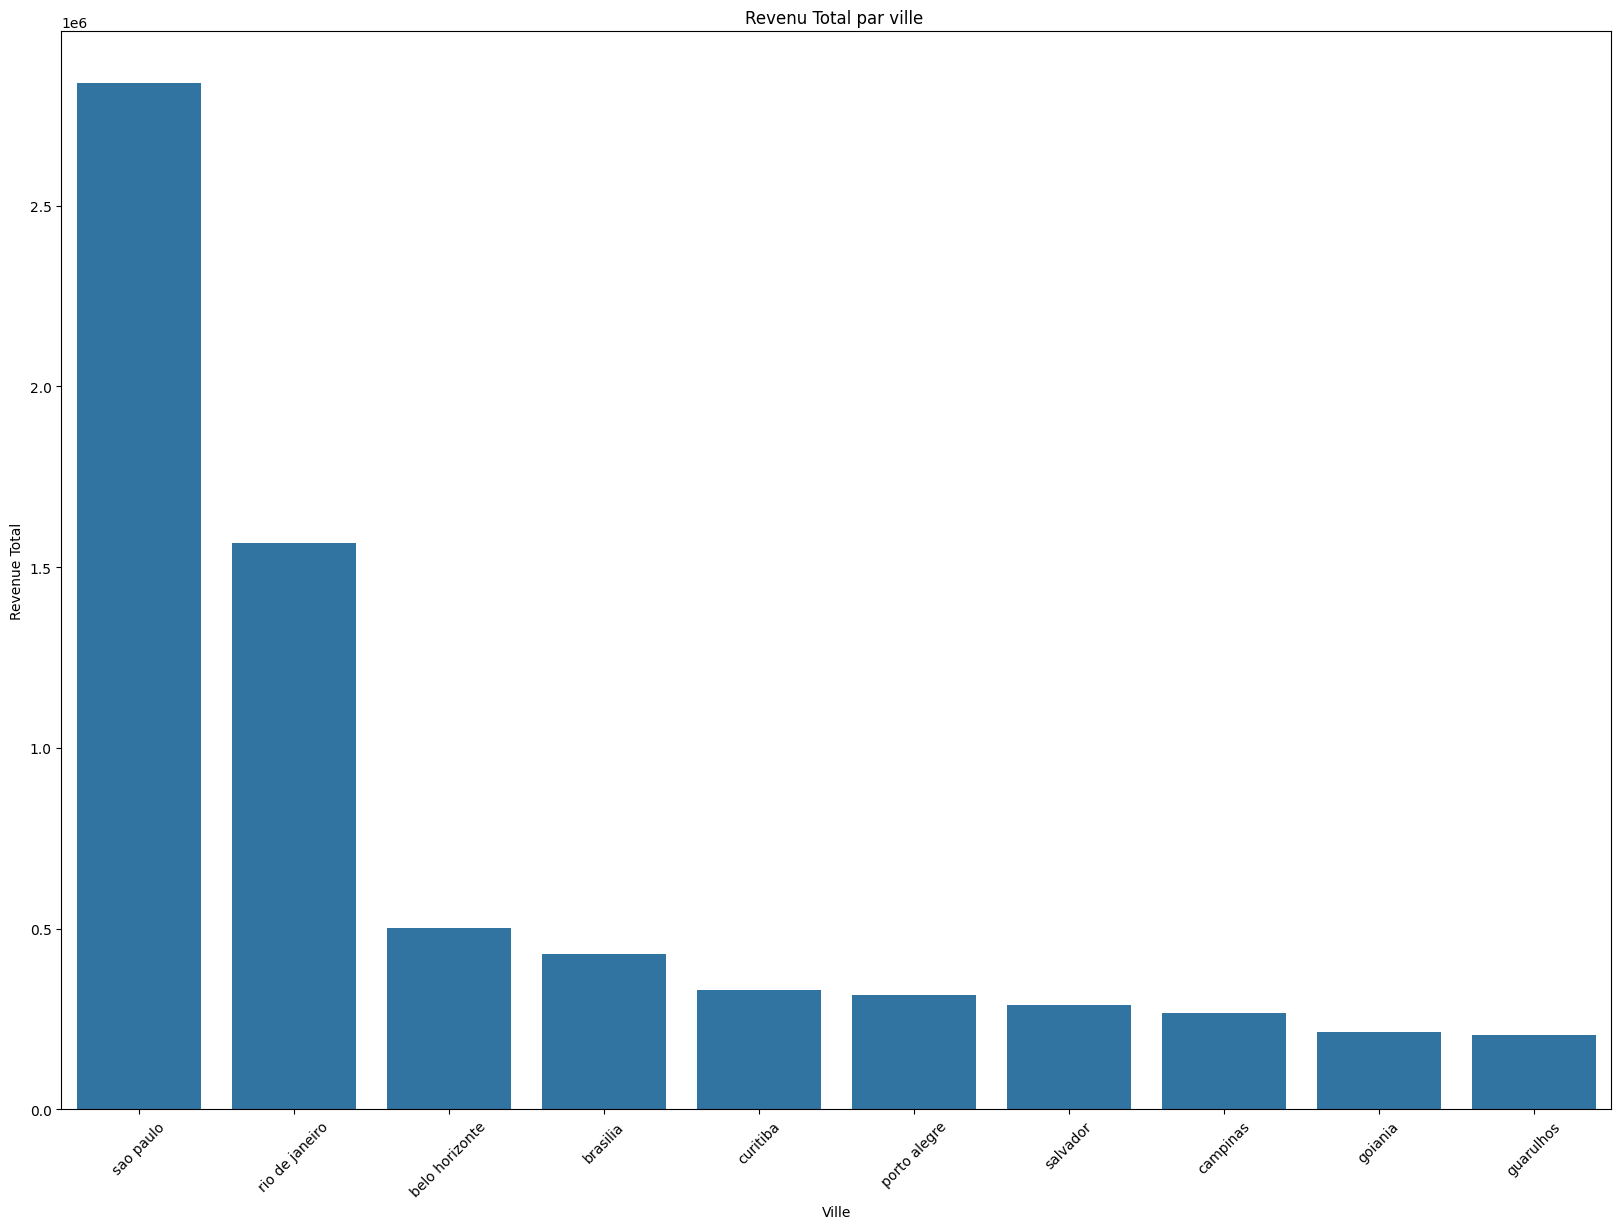

In [160]:
plt.figure(figsize=(20, 14))
sns.barplot(x='customer_city', y='total_revenue', data=analysis_data.head(10))
plt.title('Revenu Total par ville ')
plt.xlabel('Ville')
plt.ylabel('Revenue Total')
plt.xticks(rotation=45)
plt.show()


/var/folders/n9/ltr935ls6qv1qwhk40kvyl1w0000gp/T/ipykernel_10965/2591013904.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_cities.index, y=top_10_cities.values, palette='viridis')


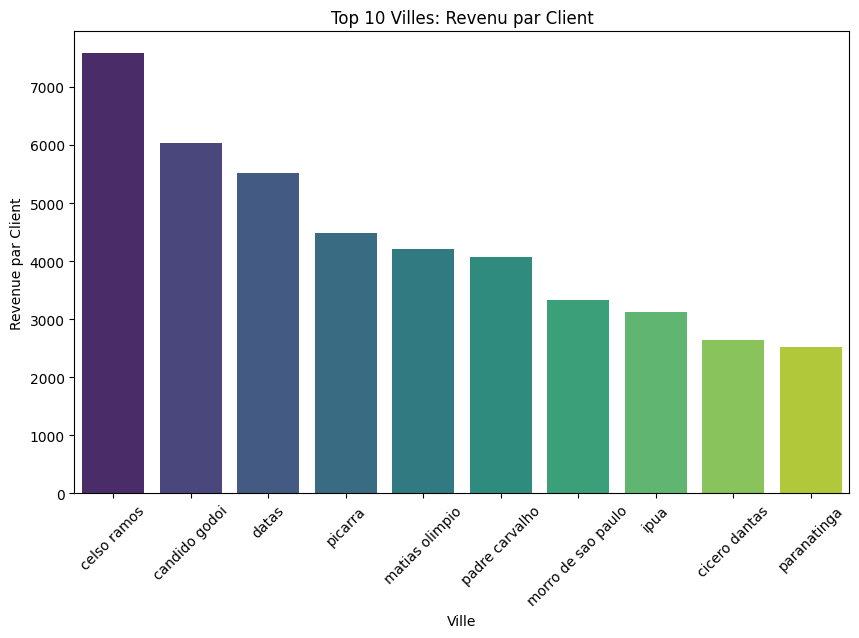

In [161]:
# Calculer les métriques : CA par client, CA par habitant et pénétration de marché
analysis_data['CA_per_Client'] = analysis_data['total_revenue'] / analysis_data['num_clients']
analysis_data['CA_per_Capita'] = analysis_data['total_revenue'] / analysis_data['IBGE_RES_POP']
analysis_data['Market_Penetration'] = (analysis_data['num_clients'] / analysis_data['IBGE_RES_POP']) * 100

revenue_per_client = analysis_data.groupby('customer_city')['CA_per_Client'].mean().sort_values(ascending=False)
top_10_cities = revenue_per_client.head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_cities.index, y=top_10_cities.values, palette='viridis')
plt.title('Top 10 Villes: Revenu par Client')
plt.xlabel('Ville')
plt.ylabel('Revenue par Client')
plt.xticks(rotation=45)
plt.show()

analysis_data['CA_per_Capita'] = analysis_data['total_revenue'] / analysis_data['IBGE_RES_POP']

# Trier les données par CA par habitant
analysis_data_sorted = analysis_data.sort_values(by='CA_per_Capita', ascending=False)


/var/folders/n9/ltr935ls6qv1qwhk40kvyl1w0000gp/T/ipykernel_10965/1252979365.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_30_cities.index, y=top_30_cities.values, palette='viridis')


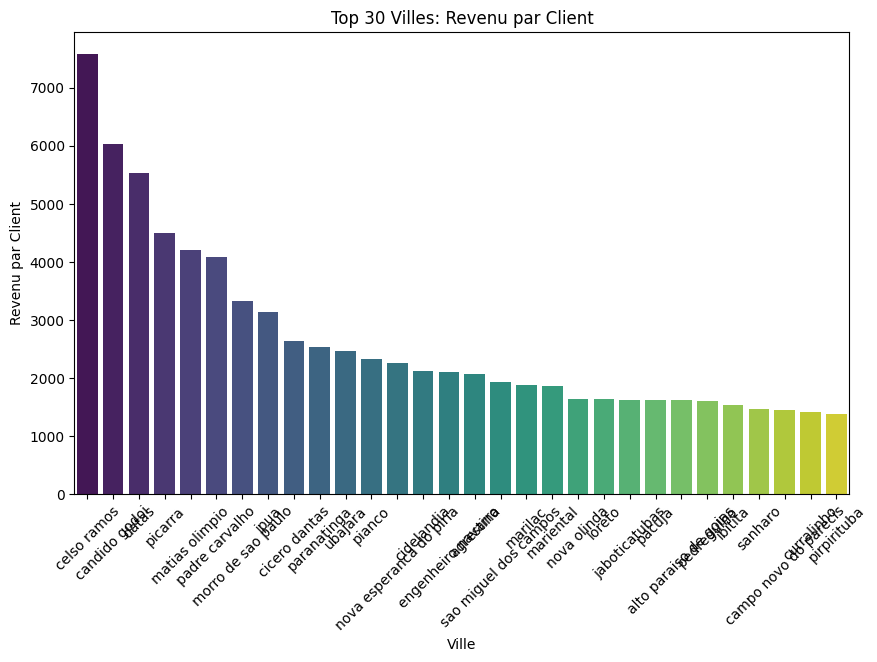

In [162]:
# Calculer les métriques : CA par client, CA par habitant et pénétration du marché
analysis_data['CA_per_Client'] = analysis_data['total_revenue'] / analysis_data['num_clients']
analysis_data['CA_per_Capita'] = analysis_data['total_revenue'] / analysis_data['IBGE_RES_POP']
analysis_data['Market_Penetration'] = (analysis_data['num_clients'] / analysis_data['IBGE_RES_POP']) * 100

revenue_per_client = analysis_data.groupby('customer_city')['CA_per_Client'].mean().sort_values(ascending=False)
top_30_cities = revenue_per_client.head(30)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_30_cities.index, y=top_30_cities.values, palette='viridis')
plt.title('Top 30 Villes: Revenu par Client')
plt.xlabel('Ville')
plt.ylabel('Revenu par Client')
plt.xticks(rotation=45)
plt.show()

/var/folders/n9/ltr935ls6qv1qwhk40kvyl1w0000gp/T/ipykernel_10965/677536077.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='CA_per_Capita', y='customer_city', data=top_10_cities, palette='viridis')


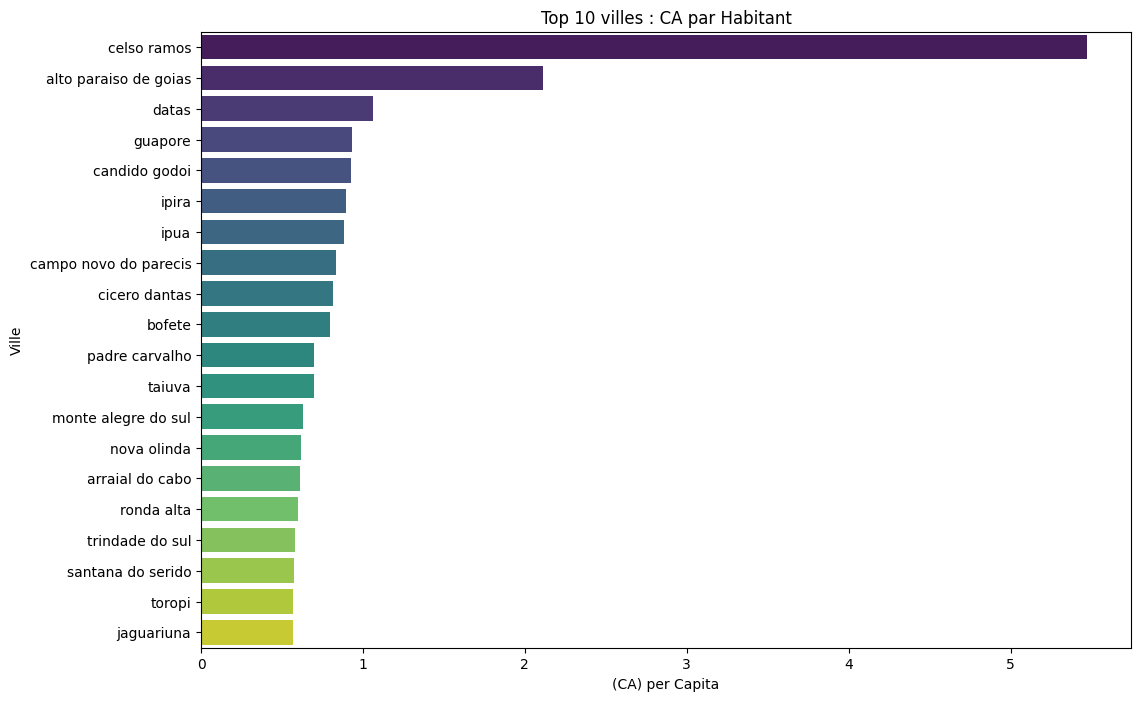

In [163]:
# Sélectionner les 10 villes principales
top_10_cities = analysis_data_sorted.head(20)
plt.figure(figsize=(12, 8))
sns.barplot(x='CA_per_Capita', y='customer_city', data=top_10_cities, palette='viridis')
plt.title('Top 10 villes : CA par Habitant')
plt.xlabel('(CA) per Capita')
plt.ylabel('Ville')
plt.show()


/var/folders/n9/ltr935ls6qv1qwhk40kvyl1w0000gp/T/ipykernel_10965/2354396659.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='CITY', y='total_revenue', data=top_30_cities_revenue, palette='viridis')


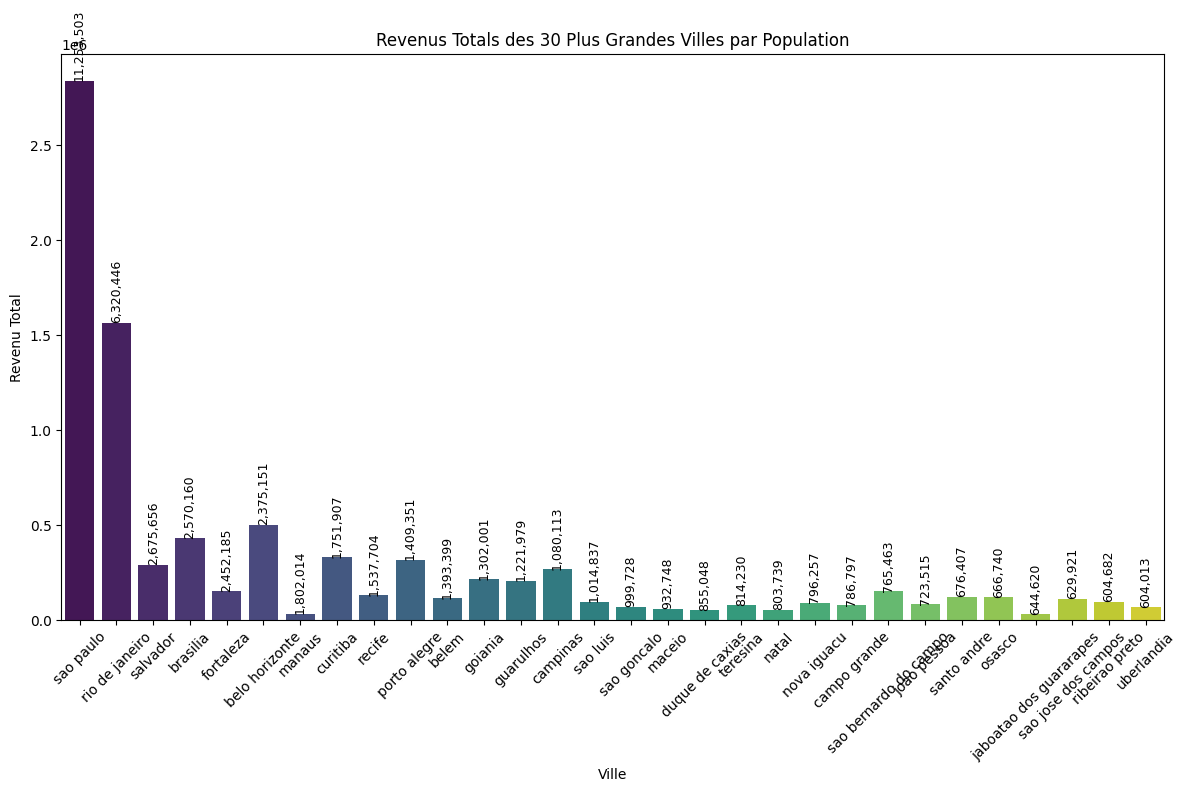

In [164]:
# Sélectionner les 30 plus grandes villes en termes de population
top_30_cities_by_population = cleaned_data.sort_values(by='IBGE_RES_POP', ascending=False).head(30)

# Calculer les revenus totaux par ville
total_revenue_by_city['customer_city'] = total_revenue_by_city['customer_city'].apply(lambda x: unidecode(x.lower()))

# Fusionner les données pour obtenir les revenus pour les 30 plus grandes villes
top_30_cities_revenue = pd.merge(top_30_cities_by_population, total_revenue_by_city, left_on='CITY', right_on='customer_city', how='inner')

# Créer un graphique
plt.figure(figsize=(12, 8))
barplot = sns.barplot(x='CITY', y='total_revenue', data=top_30_cities_revenue, palette='viridis')
plt.title('Revenus Totals des 30 Plus Grandes Villes par Population')
plt.xlabel('Ville')
plt.ylabel('Revenu Total')
plt.xticks(rotation=45)

for index, row in top_30_cities_revenue.iterrows():
    barplot.text(index, row['total_revenue'], f"{int(row['IBGE_RES_POP']):,}", color='black', ha="center", va='bottom', fontsize=9, rotation=90)

plt.tight_layout()
plt.show()

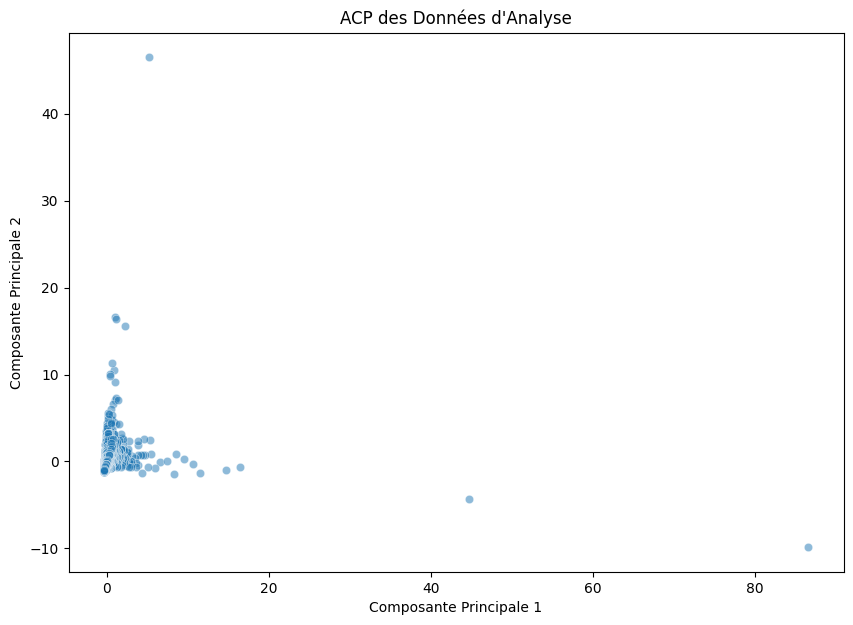

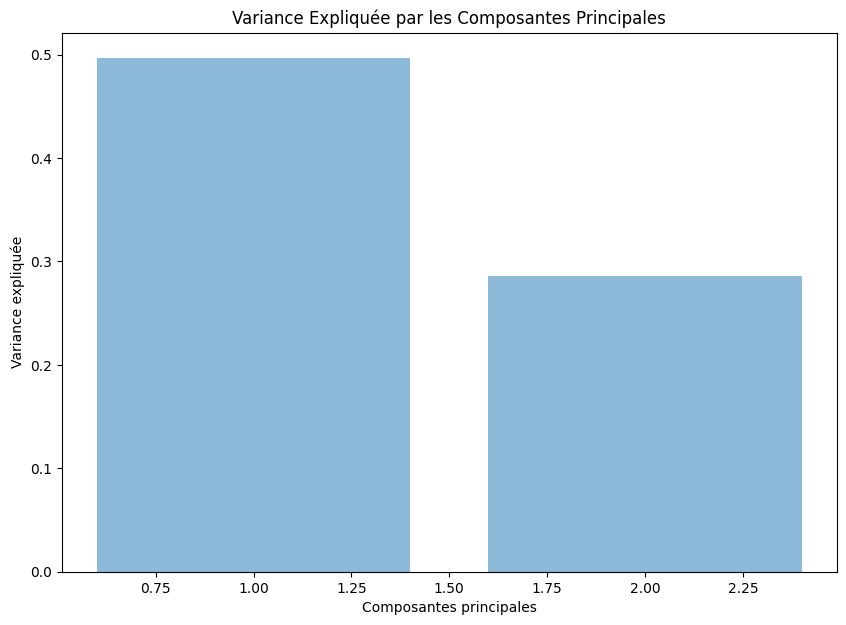

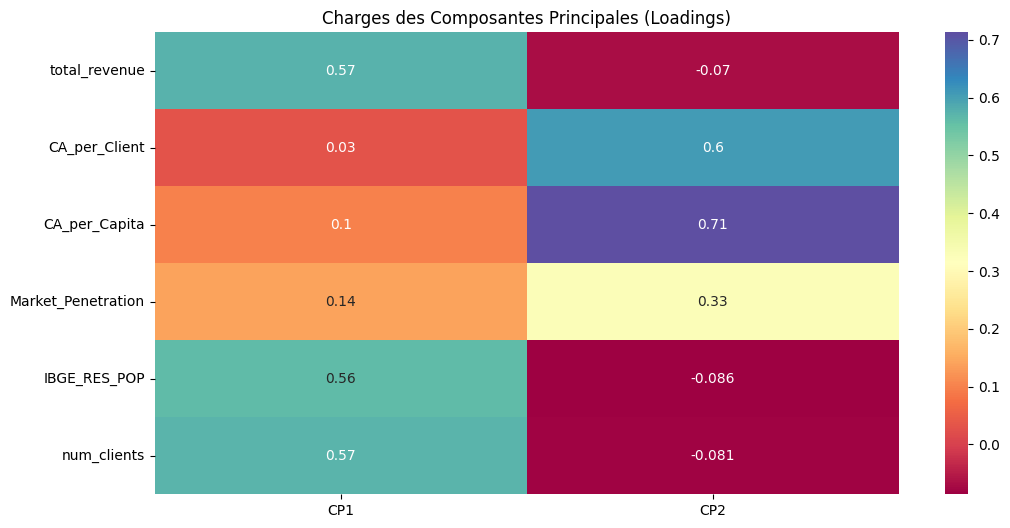

In [165]:
# ACP

# Sélectionner les colonnes numériques pertinentes pour l'ACP
numeric_cols = ['total_revenue', 'CA_per_Client', 'CA_per_Capita', 'Market_Penetration', 'IBGE_RES_POP', 'num_clients']
data_for_pca = analysis_data[numeric_cols].dropna()

# Standardiser les données
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_for_pca)

# Appliquer l'ACP
pca = PCA(n_components=2)  # Réduire à 2 dimensions pour la visualisation
pca_result = pca.fit_transform(scaled_data)

# Créer un DataFrame avec les résultats de l'ACP
pca_df = pd.DataFrame(data=pca_result, columns=['Composante Principale 1', 'Composante Principale 2'])

# Visualiser les résultats de l'ACP
plt.figure(figsize=(10, 7))
sns.scatterplot(x='Composante Principale 1', y='Composante Principale 2', data=pca_df, alpha=0.5)
plt.xlabel('Composante Principale 1')
plt.ylabel('Composante Principale 2')
plt.title('ACP des Données d\'Analyse')
plt.show()

# Variance expliquée par chaque composante principale
explained_variance = pca.explained_variance_ratio_
plt.figure(figsize=(10, 7))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.5, align='center')
plt.ylabel('Variance expliquée')
plt.xlabel('Composantes principales')
plt.title('Variance Expliquée par les Composantes Principales')
plt.show()

# Visualiser les charges des composantes principales
loadings = pd.DataFrame(pca.components_.T, columns=['CP1', 'CP2'], index=data_for_pca.columns)
plt.figure(figsize=(12, 6))
sns.heatmap(loadings, annot=True, cmap='Spectral')
plt.title('Charges des Composantes Principales (Loadings)')
plt.show()
